In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kushagratandon12/diabetic-retinopathy-balanced")

print("Path to dataset files:", path)

100%|██████████| 1.90G/1.90G [00:17<00:00, 114MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1


In [ ]:
import os
import gc
import cv2
import glob
import random
import numpy as np
import pandas as pd
from os import path
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
#Hyper-Parameter Declarations
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_SHAPE=(IMG_WIDTH,IMG_HEIGHT)
test_data_dir = '/root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1/content/Diabetic_Balanced_Data/test'
training_data_dir = '/root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1/content/Diabetic_Balanced_Data/train'
validation_data_dir = '/root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1/content/Diabetic_Balanced_Data/val'

In [ ]:
def get_dataset_size(directories):
    dataset_sizes = {}
    for name, path in directories.items():
        dataset_sizes[name] = {folder: len(os.listdir(os.path.join(path, folder))) for folder in os.listdir(path)}
    return dataset_sizes

In [ ]:
directories = {
    'train': training_data_dir,
    'validation': validation_data_dir,
    'test': test_data_dir
}

dataset_sizes = get_dataset_size(directories)

for name, size in dataset_sizes.items():
    print(f"{name} set:\n{size}\n")

train set:
{'4': 7000, '3': 7000, '0': 7000, '2': 7000, '1': 6792}

validation set:
{'4': 2000, '3': 2000, '0': 2000, '2': 2000, '1': 1940}

test set:
{'4': 1000, '3': 1000, '0': 1000, '2': 1000, '1': 971}



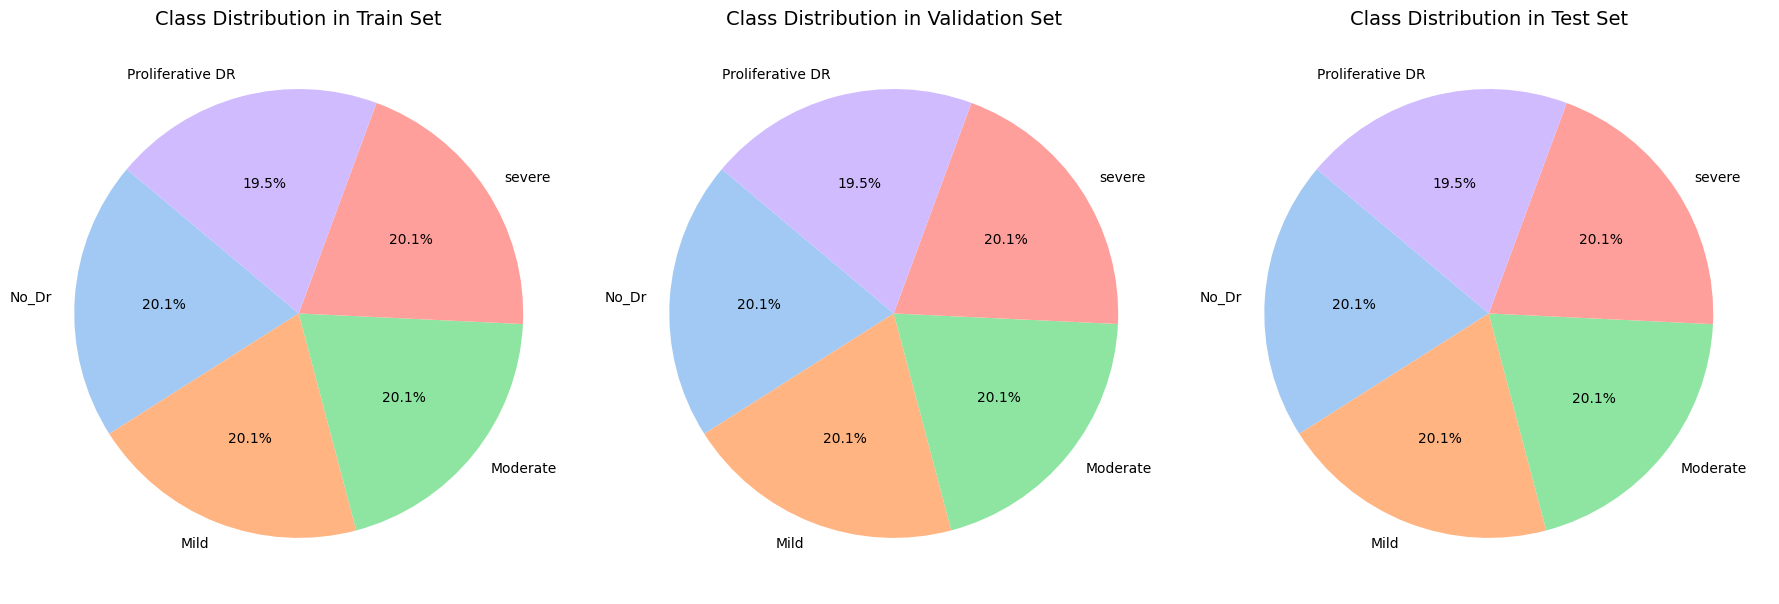

In [ ]:
labels = ['No_Dr', 'Mild', 'Moderate', 'severe', 'Proliferative DR']

# plt.style.use('seaborn-darkgrid')
sns.set_palette('muted')

# 1. Class Distribution Pie Chart
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

datasets = ['train', 'validation', 'test']
colors = sns.color_palette('pastel')[0:5]

for i, dataset in enumerate(datasets):
    sizes = list(dataset_sizes[dataset].values())
    ax[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    ax[i].set_title(f'Class Distribution in {dataset.capitalize()} Set', fontsize=14)

plt.tight_layout()
plt.show()


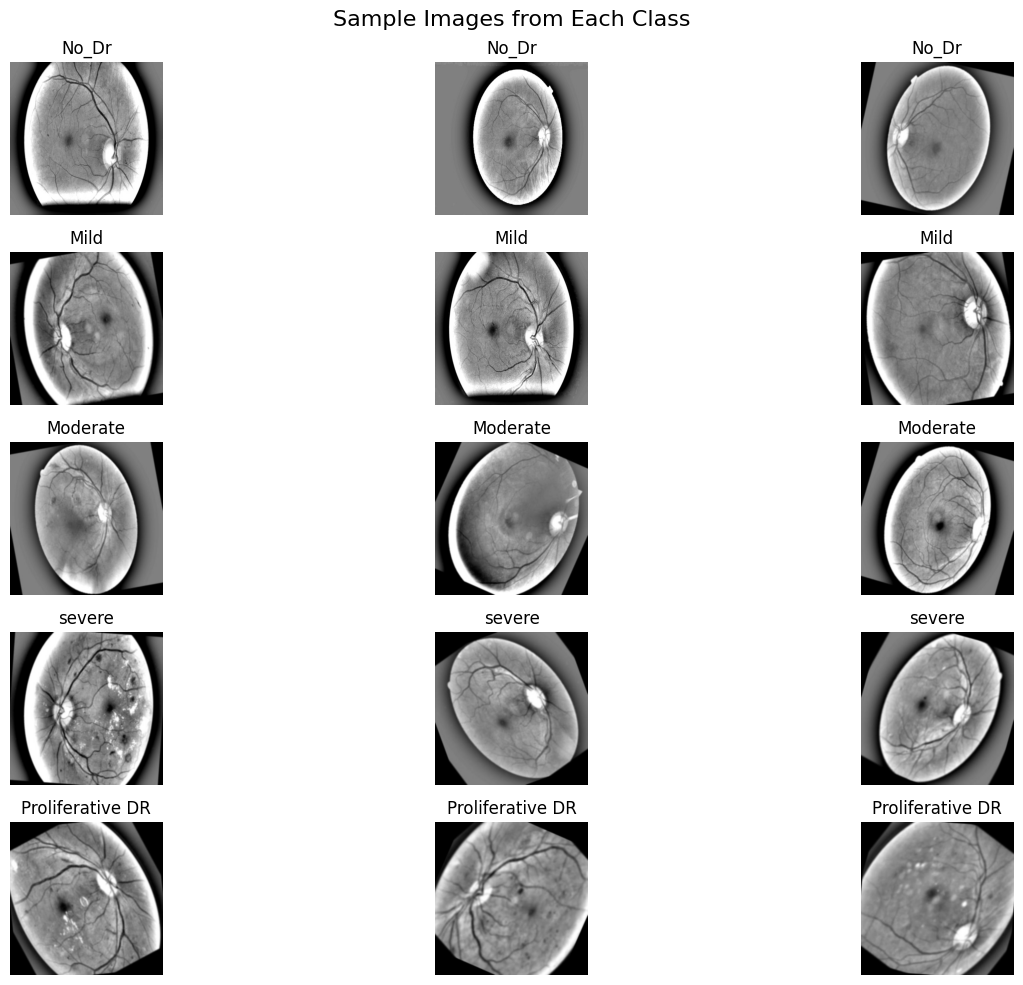

In [ ]:
def show_samples_from_each_class(data_dir, class_labels, samples_per_class=3):
    plt.figure(figsize=(15, 10))
    for i, label in enumerate(class_labels):
        folder_path = os.path.join(data_dir, str(i))
        images = os.listdir(folder_path)
        for j in range(samples_per_class):
            image_path = os.path.join(folder_path, random.choice(images))
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(class_labels), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(label)
    plt.suptitle('Sample Images from Each Class', fontsize=16)
    plt.tight_layout()
    plt.show()

show_samples_from_each_class(training_data_dir, labels)

<ipython-input-33-60d3a8e618d5>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=all_data, order=[str(i) for i in range(5)], palette='muted')


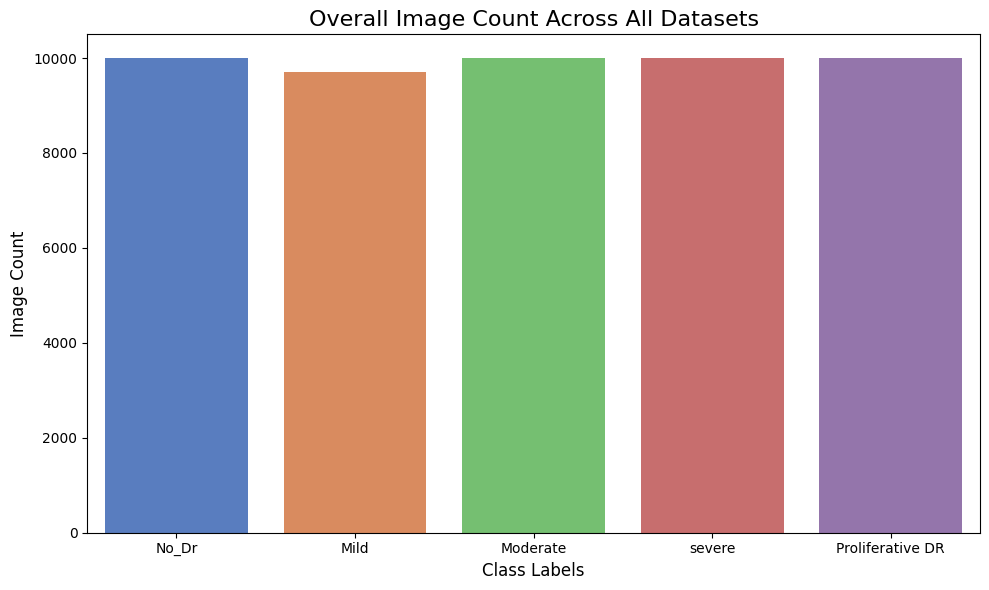

In [ ]:
labels = ['No_Dr', 'Mild', 'Moderate', 'severe', 'Proliferative DR']

plt.figure(figsize=(10, 6))
all_data = []
for dataset_name, dataset_size in dataset_sizes.items():
    for label, count in dataset_size.items():
        all_data.extend([label] * count)

sns.countplot(x=all_data, order=[str(i) for i in range(5)], palette='muted')
plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Image Count', fontsize=12)
plt.title('Overall Image Count Across All Datasets', fontsize=16)
plt.xticks(ticks=range(5), labels=labels)
plt.tight_layout()
plt.show()

In [ ]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale = 1.0/255.0,
  )

training_datagen = image_data_generator.flow_from_directory(
    training_data,
    target_size=IMG_SHAPE,
    shuffle=True,
)

validation_datagen = image_data_generator.flow_from_directory(
    validation_data,
    target_size=IMG_SHAPE,
    shuffle = True
)

test_datagen = image_data_generator.flow_from_directory(
    test_data,
    target_size=IMG_SHAPE,
    shuffle=True)

Found 34792 images belonging to 5 classes.
Found 9940 images belonging to 5 classes.
Found 4971 images belonging to 5 classes.


In [ ]:
%load_ext tensorboard
from datetime import datetime
import os

In [ ]:
classes=['No_Dr','Mild','Moderate','severe','Proliferative DR']

In [ ]:
def define_model(n_layers=45,BASE_MODEL='ResNet50V2'):
    if BASE_MODEL =='ResNet50V2':
        # Pre-trained model with MobileNetV2
        base_model = ResNet50V2(input_shape=(IMG_WIDTH,IMG_HEIGHT,3),include_top=False,weights='imagenet')
        head_model = base_model
        for layers in base_model.layers[:n_layers]:
            layers.trainable=True
        head_model = head_model.output
        head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
        head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
        head_model = tf.keras.layers.Dense(1600,activation='relu')(head_model)
        head_model = tf.keras.layers.Dropout(0.2)(head_model)
        prediction_layer = tf.keras.layers.Dense(len(classes), activation='softmax')(head_model)
        model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)

    if BASE_MODEL =='InceptionV3':
        base_model = InceptionV3(input_shape=(IMG_WIDTH,IMG_HEIGHT,3),include_top=False,weights='imagenet')
        head_model = base_model
        for layers in base_model.layers[:n_layers]:
            layers.trainable=False

        head_model = head_model.output
        head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
        head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
        head_model = tf.keras.layers.Dense(1024,activation='relu')(head_model)
        head_model = tf.keras.layers.Dropout(0.5)(head_model)
        prediction_layer = tf.keras.layers.Dense(len(classes), activation='softmax')(head_model)
        model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)
    return model

# define Model
model= define_model(BASE_MODEL='ResNet50V2')

#Compilation of the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'])

In [ ]:
# filepath = '/content/drive/MyDrive/Colab Notebooks/Model_Weights/w.keras'

# # Change 'file_path' to 'filepath'
# cp_callback = ModelCheckpoint(
#                               filepath = filepath,  # Corrected argument name
#                               save_weights_only=True,
#                               monitor='val_loss',
#                               verbose=1,
#                               save_best_only=True,mode='min')

learning_rate_reduction = ReduceLROnPlateau(
                                            monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.00001)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
history = model.fit(
    training_datagen,
    epochs=12,
    steps_per_epoch=1000,
    shuffle=True,
    validation_data=validation_datagen,
    callbacks=[learning_rate_reduction,tensorboard_callback])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 421s 359ms/step - accuracy: 0.4452 - loss: 2.0750 - val_accuracy: 0.5552 - val_loss: 1.0727 - learning_rate: 1.0000e-04
Epoch 2/12
  88/1000 ━━━━━━━━━━━━━━━━━━━━ 4:28 294ms/step - accuracy: 0.6156 - loss: 0.8933

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - accuracy: 0.6203 - loss: 0.8954 - val_accuracy: 0.6099 - val_loss: 0.9336 - learning_rate: 1.0000e-04
Epoch 3/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 379s 323ms/step - accuracy: 0.6441 - loss: 0.8540 - val_accuracy: 0.6193 - val_loss: 0.8939 - learning_rate: 1.0000e-04
Epoch 4/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - accuracy: 0.7178 - loss: 0.6741 - val_accuracy: 0.6463 - val_loss: 0.8231 - learning_rate: 1.0000e-04
Epoch 5/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 325s 322ms/step - accuracy: 0.7209 - loss: 0.6677 - val_accuracy: 0.6443 - val_loss: 0.8875 - learning_rate: 1.0000e-04
Epoch 6/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - accuracy: 0.7902 - loss: 0.5086 - val_accuracy: 0.6654 - val_loss: 0.8353 - learning_rate: 1.0000e-04
Epoch 7/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 327s 322ms/step - accuracy: 0.7710 - loss: 0.5519 - val_accuracy: 0.6274 - val_loss: 0.9203 - learning_rate: 1.0000e-04
Epoch 8/12
  88/1000 ━━━━━━━━━━━━━━━━━━━━ 4:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


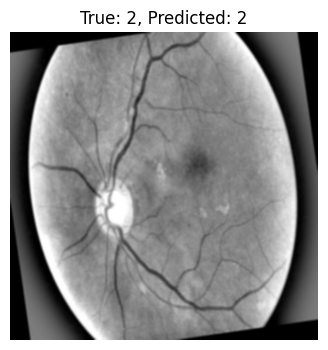

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


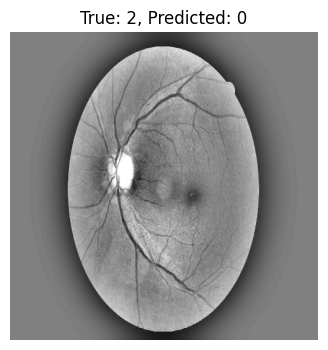

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


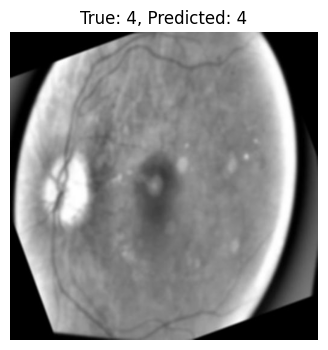

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


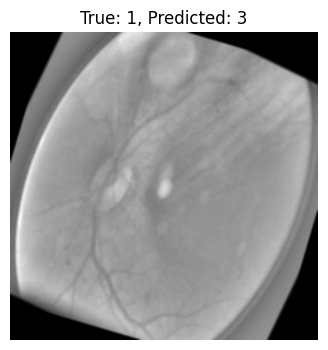

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


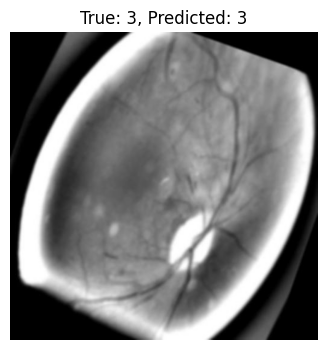

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


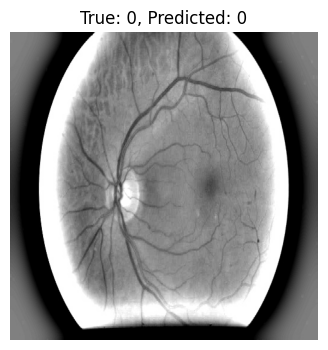

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Correct predictions: 43 out of 50
Accuracy: 86.00%


In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set the test directory path and labels
test_dir = '/root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1/content/Diabetic_Balanced_Data/test'
labels = [0, 1, 2, 3, 4]

# Get all image paths from the test directory
all_image_paths = []
true_labels = []

for label_index, label_name in enumerate(labels):
    label_dir = os.path.join(test_dir, str(label_index))
    images = [os.path.join(label_dir, img) for img in os.listdir(label_dir) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
    all_image_paths.extend(images)
    true_labels.extend([label_index] * len(images))

# Randomly select 50 images
num_samples = 50
selected_indices = random.sample(range(len(all_image_paths)), num_samples)
selected_images = [all_image_paths[i] for i in selected_indices]
selected_labels = [true_labels[i] for i in selected_indices]

# Function to preprocess images
def preprocess_image(image_path, image_size=(256, 256)):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.resize(img, image_size)
    img = np.expand_dims(img, axis=0) / 255.0
    return img

# Predict and evaluate
correct_predictions = 0
for img_path, true_label in zip(selected_images, selected_labels):
    img = preprocess_image(img_path)
    if img is None:
        continue

    prediction = model.predict(img)
    predicted_label = np.argmax(prediction)

    # Count correct predictions
    if predicted_label == true_label:
        correct_predictions += 1

    # Optionally visualize some predictions
    if random.random() < 0.1:  # Show 10% of the predictions
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
        plt.title(f"True: {labels[true_label]}, Predicted: {labels[predicted_label]}")
        plt.axis('off')
        plt.show()

# Display results
print(f"Correct predictions: {correct_predictions} out of {num_samples}")
print(f"Accuracy: {(correct_predictions / num_samples) * 100:.2f}%")
#Here i have tested 50 images of different classes manually to check their class


In [ ]:
save_path = '/root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1/content/Diabetic_Balanced_Data/model'

# Save the model
# Save the model in .h5 format
model.save('/root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1/content/Diabetic_Balanced_Data/model.h5')

print(f"Model saved successfully at: {save_path}")

Model saved successfully at: /root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1/content/Diabetic_Balanced_Data/model


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from os.path import join
diab_model = tf.keras.models.load_model('./model.h5')
shape = (256,256)
def decode_img(image_path,shape):
    img = tf.keras.preprocessing.image.load_img(filename,target_size=(shape))
    img = tf.keras.preprocessing.image.img_to_array(img) # converted to ndarray
    img = img.astype(np.float32)/255.0
    img = np.expand_dims(img,axis=0)
    return img

/root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1/content/Diabetic_Balanced_Data/test/2/5047_left._aug_12.jpeg


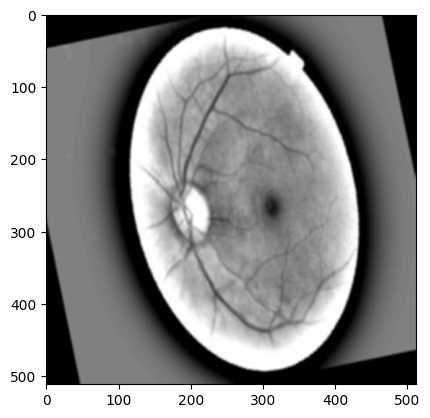

In [ ]:
import glob
import random
test_img = glob.glob('/root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1/content/Diabetic_Balanced_Data/test/*/*.jpeg')
img_select = random.randint(1,len(test_img))

print(test_img[img_select])
img = plt.imread(test_img[img_select])
plt.imshow(img,cmap = 'gray')

In [ ]:
test_data =glob.glob('/root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1/content/Diabetic_Balanced_Data/test/*/*.jpeg')
print("Test data ",len(test_data))
img_files = [os.path.basename(name) for name in test_data]
test_label = [name.split('/')[-2] for name in test_data]
test_df = pd.DataFrame({'filename':img_files,'label':test_label,})
test_df.to_csv('test_data.csv')
test_df


Test data  4971


,filename,label
0,13811_right._aug_2._aug_29.jpeg,4
1,30869_right._aug_31._aug_23.jpeg,4
2,22271_right._aug_23._aug_19.jpeg,4
3,38811_right._aug_3._aug_31._aug_4.jpeg,4
4,19471_left._aug_31._aug_15._aug_20.jpeg,4
...,...,...
4966,2129_left.jpeg,1
4967,33919_right._aug_14._aug_21.jpeg,1
4968,527_left._aug_24._aug_14.jpeg,1
4969,7773_right._aug_28.jpeg,1


In [ ]:
predictions = []
for iter,row in test_df.iterrows():
  filename = join('/root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1/content/Diabetic_Balanced_Data/test',join(row.label,row.filename))
  img = decode_img(filename,shape)
  pred = diab_model.predict(img)
  y_classes = np.argmax(pred)
  #print(y_classes)
  predictions.append(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
test_df['pred_label']=predictions
print(predictions[0])
test_df.head()

[[1.2957393e-11 2.2366910e-10 6.5312355e-07 1.2254282e-02 9.8774511e-01]]


,filename,label,pred_label
0,13811_right._aug_2._aug_29.jpeg,4,"[[1.2957393e-11, 2.236691e-10, 6.5312355e-07, ..."
1,30869_right._aug_31._aug_23.jpeg,4,"[[0.00013305224, 3.3832177e-05, 6.0067873e-06,..."
2,22271_right._aug_23._aug_19.jpeg,4,"[[2.3738683e-10, 2.0329574e-10, 4.2889206e-07,..."
3,38811_right._aug_3._aug_31._aug_4.jpeg,4,"[[2.73869e-12, 1.1562282e-09, 2.669057e-11, 0...."
4,19471_left._aug_31._aug_15._aug_20.jpeg,4,"[[5.594168e-15, 1.6062587e-13, 1.0719744e-09, ..."


In [ ]:
y_test = test_df['label'].astype(int)
y_pred = test_df['pred_label']

In [ ]:
y_pred = test_df.apply(lambda row: np.argmax(list(row['pred_label'])) , axis=1)
print(y_test)

0       4
1       4
2       4
3       4
4       4
       ..
4966    1
4967    1
4968    1
4969    1
4970    1
Name: label, Length: 4971, dtype: int64


In [ ]:
import itertools
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.57      0.64      0.60      1000
           1       0.66      0.57      0.61       971
           2       0.57      0.61      0.59      1000
           3       0.89      0.89      0.89      1000
           4       0.95      0.92      0.93      1000

    accuracy                           0.73      4971
   macro avg       0.73      0.72      0.73      4971
weighted avg       0.73      0.73      0.73      4971



<Figure size 640x480 with 0 Axes>

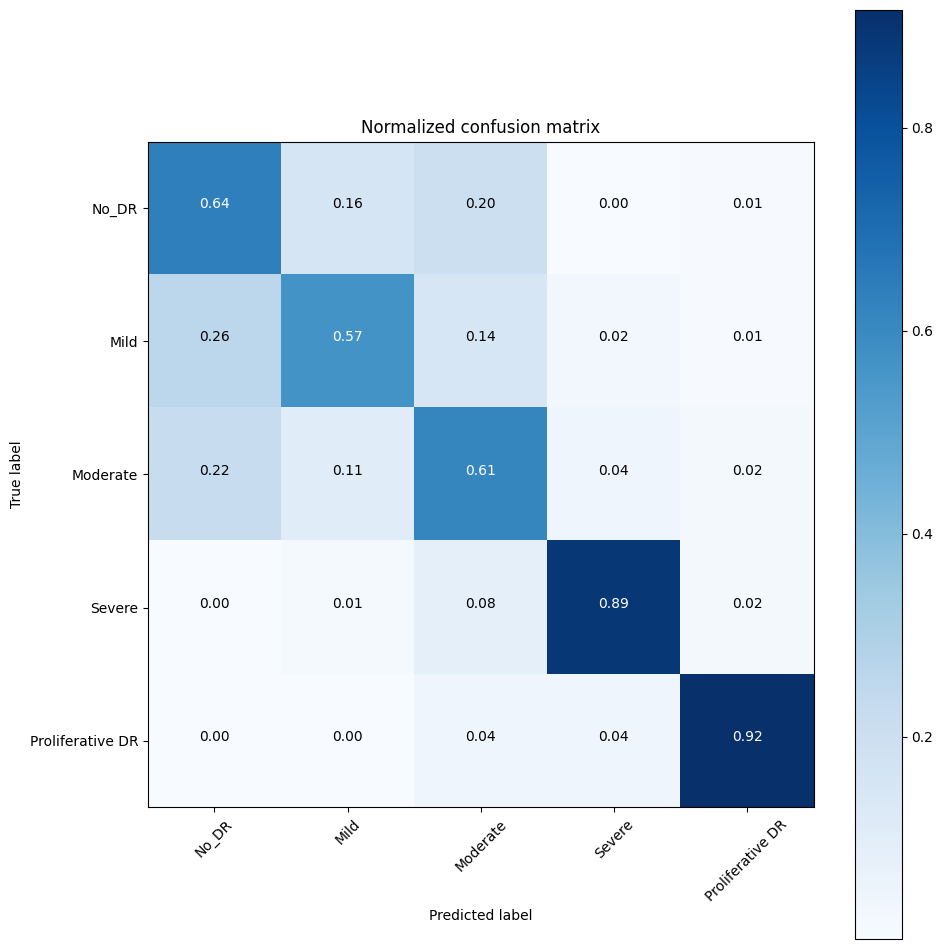

In [ ]:
classes = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

np.set_printoptions(precision=2)


# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, title='Normalized confusion matrix')
plt.show()